# Download files for this tutorial

#### IU X-Ray dataset: reports and images

In [1]:
# https://drive.google.com/file/d/1cjlIz3npsZHeGjNXPkmOlU2FHnnTo4g9/view?usp=share_link
!gdown 1cjlIz3npsZHeGjNXPkmOlU2FHnnTo4g9

Downloading...
From: https://drive.google.com/uc?id=1cjlIz3npsZHeGjNXPkmOlU2FHnnTo4g9
To: /content/iuxray_reports_and_images.zip
100% 75.4M/75.4M [00:01<00:00, 45.6MB/s]


In [2]:
!unzip -qq iuxray_reports_and_images.zip

#### Config and pretrained weights of report generation model

In [3]:
# https://drive.google.com/file/d/1as6AU8RM6KpvUlRrmC3WRptwSaeSWhEp/view?usp=share_link
!gdown 1as6AU8RM6KpvUlRrmC3WRptwSaeSWhEp

Downloading...
From: https://drive.google.com/uc?id=1as6AU8RM6KpvUlRrmC3WRptwSaeSWhEp
To: /content/pretrained-report-gen-model.zip
100% 132M/132M [00:02<00:00, 44.5MB/s]


In [4]:
!unzip pretrained-report-gen-model.zip

Archive:  pretrained-report-gen-model.zip
  inflating: metadata.json           
  inflating: model.pt                
  inflating: vocab__min_freq=5__from(qa_adapted_reports__20220629_042239.json;qa_adapted_reports__20220629_050643.json).pkl  


In [5]:
!ls .

 images
 iuxray_reports_and_images.zip
 metadata.json
 model.pt
 pretrained-report-gen-model.zip
 reports.json
 sample_data
'vocab__min_freq=5__from(qa_adapted_reports__20220629_042239.json;qa_adapted_reports__20220629_050643.json).pkl'


#### Install torchmetrics

In [6]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 35.7 MB/s 


#  Import libraries we are going to use

In [7]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchmetrics import BLEUScore

from nltk.tokenize import wordpunct_tokenize

import matplotlib.pyplot as plt
from matplotlib.image import imread

import textwrap
from pprint import pprint
from termcolor import colored

from PIL import Image as PILImage
from IPython.display import Image

import math
import json
import pickle
import os

#### Utility functions to load files

In [8]:
def load_json_file(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_pickle_file(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Conditional Report Generator (**CRG**)

![picture](https://drive.google.com/uc?id=1LWceaC6wBtUfhyKFZeT69XRShs38VHv0)

____

# CRG conditioned on a CheXpert labeler topic

![picture](https://drive.google.com/uc?id=11u032QVvfeQZ2vsEXkT9RJ4M-2zODmT1)

____

# CRG conditiond on a mined topic

![picture](https://drive.google.com/uc?id=1EHkZlhTWYlil0TBZNm4CwLAQ82T9WbHe)


# (Parenthesis 1: CheXpert labeler)

Available at: https://github.com/stanfordmlgroup/chexpert-labeler

![picture](https://drive.google.com/uc?id=10bBg6PdN48fMrzggTyONZE-pY43B9V6g)

# (Parenthesis 2: Splitting Reports into Topics)

![picture](https://drive.google.com/uc?id=1Pu5qSsQm17W4LSjC0NSSZs4Jc1O-25dK)


### Utility code

In [26]:
class RawImageEncoding:
    DENSENET_121 = 'densenet-121'
    CLIP_RESNET = 'clip-resnet'
    CLIP_VIT = 'clip-vit'
    CLIP_VIT__HUGGINGFACE = 'clip-vit-huggingface'
    CLIP_VIT_LARGE__HUGGINGFACE = 'clip-vit-large-huggingface'
    CLIP_RESNET__HUGGINGFACE = 'clip-resnet-huggingface'

class VisualInputMode:
    RAW_IMAGE = 'raw-image'
    PRECOMP_FEAT = 'precomp-feat' # precomputed visual features
    HYBRID = 'hybrid'

class QuestionEncoding:
    BILSTM = 'bilstm'
    ONE_HOT = 'one-hot'

class CHEXPERT_TASKS:
    CLASSIFICATION = 'classification'
    VQA = 'vqa'

class AnswerDecoding:
    LSTM = 'lstm'
    TRANSFORMER  = 'transformer'

CHEXPERT_LABELS = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',    
    'Lung Lesion',
    'Lung Opacity',
    'Edema',
    'Consolidation',    
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices',
]
CXR14_LABELS = [
    'No Finding',
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Effusion',
    'Emphysema',
    'Fibrosis',
    'Hernia',
    'Infiltration',
    'Mass',
    'Nodule',
    'Pleural_Thickening',
    'Pneumonia',
    'Pneumothorax',
]
VINBIG_LABELS = [
    'Aortic enlargement', 'Atelectasis', 'Calcification',
    'Cardiomegaly', 'Clavicle fracture', 'Consolidation', 'Edema',
    'Emphysema', 'Enlarged PA', 'ILD', 'Infiltration', 'Lung Opacity',
    'Lung cavity', 'Lung cyst', 'Mediastinal shift', 'Nodule/Mass',
    'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
    'Pulmonary fibrosis', 'Rib fracture', 'Other lesion', 'COPD',
    'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other disease',
    'No finding',
]

CHEXPERT_GENDERS = ['Female', 'Male']
CHEXPERT_ORIENTATIONS = ['FrontalAP', 'Lateral', 'FrontalPA']
CXR14_GENDERS = ['F', 'M']
CXR14_ORIENTATIONS = ['AP', 'PA']
MIMICCXR_IMAGE_ORIENTATIONS = ['UNKNOWN', 'PA', 'AP']
IUXRAY_IMAGE_ORIENTATIONS = ['lateral-left', 'lateral-right', 'frontal']

def does_include_image(visual_input_mode):
    return visual_input_mode in (VisualInputMode.RAW_IMAGE, VisualInputMode.HYBRID)

def does_include_visual_features(visual_input_mode):
    return visual_input_mode in (VisualInputMode.PRECOMP_FEAT, VisualInputMode.HYBRID)

def freeze_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

# Transformer Decoder

In [27]:
class PositionalEncoding(nn.Module):
  
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerAnswerDecoder(nn.Module):
  
    def __init__(
        self,
        embedding_table,
        embed_size,
        hidden_size,
        question_vec_size,
        image_local_feat_size,
        image_global_feat_size,
        nhead,
        dim_feedforward,
        num_layers,
        start_idx,
        vocab_size,
        dropout_prob,
        use_local_features = True,
    ):
        assert embed_size == hidden_size
        super().__init__()
        self.embedding_table = embedding_table
        self.embed_size = embed_size
        self.hidden_size = hidden_size    
        self.register_buffer('start_idx', torch.tensor(start_idx))
        self.vocab_size = vocab_size
        self.pos_encoder = PositionalEncoding(hidden_size, dropout_prob)
        self.decoder = nn.TransformerDecoder(
        nn.TransformerDecoderLayer(
            d_model=hidden_size, nhead=nhead, dim_feedforward=dim_feedforward
        ), num_layers=num_layers)
        self.W_vocab = nn.Linear(hidden_size, vocab_size)
        self.use_local_features = use_local_features
        if use_local_features:
            self.W_local_feat = nn.Linear(image_local_feat_size, hidden_size)
        self.W_global_feat = nn.Linear(image_global_feat_size, hidden_size)
        self.W_q = nn.Linear(question_vec_size, hidden_size)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def get_image_question_memory(self, local_feat, global_feat, question_vectors):
        # merge image and question
        batch_size = global_feat.size(0)
        if self.use_local_features:
            image_question_memory = torch.cat((
                self.W_local_feat(local_feat),
                self.W_global_feat(global_feat).view(batch_size, 1, -1),
                self.W_q(question_vectors).view(batch_size, 1, -1),
            ), 1)
        else:
            image_question_memory = torch.cat((
                self.W_global_feat(global_feat).view(batch_size, 1, -1),
                self.W_q(question_vectors).view(batch_size, 1, -1),
            ), 1)
        return image_question_memory
    
    def teacher_forcing_decoding(self, local_feat, global_feat, question_vectors, answers, device):
        batch_size, max_answer_length = answers.shape
        answer_embeddings = self.pos_encoder(self.embedding_table(answers.permute(1,0)))
        # assert answer_embeddings.shape == (max_answer_length, batch_size, self.embed_size)
        tgt_mask = self.generate_square_subsequent_mask(max_answer_length).to(device)
        image_question_memory = self.get_image_question_memory(local_feat, global_feat, question_vectors)
        image_question_memory = image_question_memory.permute(1,0,2)
        decoded = self.decoder(answer_embeddings,
                            image_question_memory,
                            tgt_mask=tgt_mask)        
        vocab_logits = self.W_vocab(decoded)
        vocab_logits = vocab_logits.permute(1, 0, 2)
        # assert vocab_logits.shape == (batch_size, max_answer_length, self.vocab_size)
        return vocab_logits

    def greedy_search_decoding(self, local_feat, global_feat, question_vectors, max_answer_length, device):
        batch_size = global_feat.size(0)
        image_question_memory = self.get_image_question_memory(local_feat, global_feat, question_vectors)
        image_question_memory = image_question_memory.permute(1,0,2)
        decoded_tokens = self.start_idx.expand(batch_size).unsqueeze(0)
        output = []

        # generation loop
        while len(output) < max_answer_length:
            decoded_embedding = self.pos_encoder(self.embedding_table(decoded_tokens))
            tgt_mask = self.generate_square_subsequent_mask(decoded_embedding.size(0)).to(device)
            decoded = self.decoder(decoded_embedding,
                                image_question_memory,
                                tgt_mask=tgt_mask)
            vocab_logits = self.W_vocab(decoded[-1])
            output.append(torch.argmax(vocab_logits, 1))
            assert vocab_logits.shape == (batch_size, self.vocab_size)
            next_tokens = vocab_logits.argmax(1)
            next_tokens = next_tokens.unsqueeze(0)
            assert next_tokens.shape == (1, batch_size)
            decoded_tokens = torch.cat((decoded_tokens, next_tokens), 0)

        output = torch.stack(output, 1)
        assert output.shape == (batch_size, max_answer_length)
        return output

    def forward(
        self, local_feat, global_feat, question_vectors, device,
        answers=None, max_answer_length=None, mode='train',
    ):
        if mode == 'train':
            assert answers is not None
            return self.teacher_forcing_decoding(
                    local_feat, global_feat, question_vectors, answers, device)
        else:
            assert max_answer_length is not None
            return self.greedy_search_decoding(
                    local_feat, global_feat, question_vectors,
                    max_answer_length, device)

# CRG's main code

In [28]:
def create_densenet121_feature_extractor(
    pretrained_weights_path=None,
    imagenet_pretrained=False,
    drop_rate=0.0,
):
    # Load pre-trained CNN weights
    if pretrained_weights_path:
        densenet = torchvision.models.densenet121(pretrained=False, drop_rate=drop_rate)
        pretrained_weights = torch.load(pretrained_weights_path, map_location='cuda')
        densenet.load_state_dict(pretrained_weights, strict=False)
        print("DenseNet121's pretrained weights loaded from", pretrained_weights_path)
    elif imagenet_pretrained:
        densenet = torchvision.models.densenet121(pretrained=True, drop_rate=drop_rate)
        print("DenseNet121's pretrained weights loaded from ImageNet")
    else:
        densenet = torchvision.models.densenet121(pretrained=False, drop_rate=drop_rate)
    return densenet.features

class ConditionalReportGenerator(nn.Module):

    def __init__(self,
                 # Vocab args
                 vocab_size, embed_size,
                 start_idx=None,
                 eos_idx=None,
                 padding_idx=None,
                 # Image Encoder args
                 visual_input_mode=VisualInputMode.RAW_IMAGE,
                 raw_image_encoding=RawImageEncoding.DENSENET_121,
                 image_local_feat_size=None,
                 freeze_image_encoder=False,
                 image_encoder_pretrained_weights_path=None,
                 imagenet_pretrained=True,
                 mlp_in_dim=None,
                 mlp_out_dim=None,
                 mlp_hidden_dims=None,
                 clip_version=None,
                 # Question Encoder args
                 question_encoding = QuestionEncoding.BILSTM,
                 question_vec_size=None,
                 question_hidden_size=None,
                 # Answer Decoder args
                 answer_decoding =  AnswerDecoding.LSTM,
                 answer_hidden_size=None,
                 n_lstm_layers=None,
                 transf_dec_nhead=None,
                 transf_dec_dim_forward=None,
                 transf_dec_num_layers=None,
                 # Auxiliary tasks args
                 classify_tags=False,
                 classify_orientation=False,
                 classify_chexpert=False,
                 classify_questions=False,
                 n_medical_tags=None,
                 n_questions=None,
                 n_questions_aux_task=None,
                 use_cxr14=False,
                 use_vinbig=False,
                 merge_findings=False,
                 n_findings=None,
                 # Other args
                 chexpert_mode=None,
                 dropout_prob=0,
                 device=None,
                 **unused_kwargs,
                 ): 
        super().__init__()

        print('CRG():')

        print('  image_encoder_pretrained_weights_path', image_encoder_pretrained_weights_path)

        self.chexpert_mode = chexpert_mode
        if chexpert_mode == CHEXPERT_TASKS.VQA:
            assert question_encoding == QuestionEncoding.ONE_HOT
        
        # Init vocab embedding table
        self.embedding_table = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_size,
            padding_idx=0,
        )
        
        # Init Visual Module
        self.visual_input_mode = visual_input_mode
        self.clip_version = clip_version
        self._init_visual_module(visual_input_mode, raw_image_encoding, image_encoder_pretrained_weights_path,
                            imagenet_pretrained, image_local_feat_size, mlp_in_dim, mlp_out_dim, mlp_hidden_dims,
                            clip_version, freeze_image_encoder)
        
        # Init Question Encoder
        self.question_encoding = question_encoding
        self._init_question_encoder(question_encoding, question_hidden_size=question_hidden_size,
                        embed_size=embed_size, question_vec_size=question_vec_size,
                        vocab_size=vocab_size, start_idx=start_idx, n_questions=n_questions,
                        device=device)
          
        # Init Answer Decoder
        self.answer_decoding = answer_decoding
        self._init_answer_decoder(image_local_feat_size, question_vec_size, embed_size,
                            answer_hidden_size, n_lstm_layers, start_idx, eos_idx, padding_idx, vocab_size,
                            transf_dec_nhead, transf_dec_dim_forward, transf_dec_num_layers, dropout_prob,
                            use_local_features=does_include_image(visual_input_mode))
            
        # Init auxiliary tasks
        self._init_auxiliary_tasks(classify_tags, classify_orientation, classify_chexpert, classify_questions,
                              chexpert_mode, use_cxr14, use_vinbig, n_medical_tags, n_questions_aux_task,
                              merge_findings=merge_findings, n_findings=n_findings)

        # Logging
        print(f'  n_questions = {n_questions}\n  n_questions_aux_task = {n_questions_aux_task}\n'
              f'  question_encoding = {question_encoding}\n  answer_decoding = {answer_decoding}\n'
              f'  visual_input_mode = {visual_input_mode}\n  name = {self.name}')

    def _init_visual_module(self, visual_input_mode, raw_image_encoding, image_encoder_pretrained_weights_path,
                            imagenet_pretrained, image_local_feat_size, mlp_in_dim, mlp_out_dim, mlp_hidden_dims,
                            clip_version, freeze_image_encoder):
        global_feat_size = 0
        
        if does_include_image(visual_input_mode):
            self._init_raw_image_encoder(raw_image_encoding, image_encoder_pretrained_weights_path,
                                         imagenet_pretrained, clip_version, freeze_image_encoder)
            global_feat_size += self._get_raw_image_encoder_global_feat_size(image_local_feat_size)
        
        if does_include_visual_features(visual_input_mode):
            self._init_mlp_visual_feat_encoder(mlp_in_dim, mlp_out_dim, mlp_hidden_dims, freeze_image_encoder)
            global_feat_size += mlp_out_dim
        
        assert global_feat_size > 0
        self.global_feat_size = global_feat_size
        print('  self.global_feat_size =', self.global_feat_size)

    def _get_raw_image_encoder_global_feat_size(self, image_local_feat_size):
        if self.raw_image_encoding == RawImageEncoding.DENSENET_121:
            return 2 * image_local_feat_size
        # if self.raw_image_encoding == RawImageEncoding.CLIP_VIT:
        #     return CLIP_VIT_GLOBAL_FEAT_SIZE
        # if self.raw_image_encoding == RawImageEncoding.CLIP_RESNET:
        #     return CLIP_RESNET_GLOBAL_FEAT_SIZE
        # if self.raw_image_encoding == RawImageEncoding.CLIP_VIT__HUGGINGFACE:
        #     return HUGGINGFACE_CLIP_VIT_GLOBAL_FEAT_SIZE
        # if self.raw_image_encoding == RawImageEncoding.CLIP_VIT_LARGE__HUGGINGFACE:
        #     return HUGGINGFACE_CLIP_VIT_LARGE_GLOBAL_FEAT_SIZE
        assert False
    
    def _init_raw_image_encoder(self, raw_image_encoding, pretrained_weights_path,
                                imagenet_pretrained, clip_version, freeze_image_encoder):
        self.raw_image_encoding = raw_image_encoding        
        if raw_image_encoding == RawImageEncoding.DENSENET_121:
            self.raw_image_encoder = create_densenet121_feature_extractor(pretrained_weights_path, imagenet_pretrained)
        # elif raw_image_encoding == RawImageEncoding.CLIP_RESNET:
        #     self.raw_image_encoder = create_clip_resnet_feature_extractor(clip_version, pretrained_weights_path)
        # elif raw_image_encoding == RawImageEncoding.CLIP_VIT:
        #     self.raw_image_encoder = create_clip_vit_feature_extractor(clip_version, pretrained_weights_path)
        # elif raw_image_encoding == RawImageEncoding.CLIP_VIT__HUGGINGFACE or \
        #      raw_image_encoding == RawImageEncoding.CLIP_VIT_LARGE__HUGGINGFACE:
        #     self.raw_image_encoder = create_huggingface_clip_vit_feature_extractor(clip_version, pretrained_weights_path)
        else: assert False, f'Unknown image encoding {raw_image_encoding}'
        if freeze_image_encoder: freeze_parameters(self.raw_image_encoder)

    def _init_mlp_visual_feat_encoder(self, mlp_in_dim, mlp_out_dim, mlp_hidden_dims, freeze_image_encoder):
        # self.mlp_vf_encoder = MLP(in_dim=mlp_in_dim, out_dim=mlp_out_dim, hidden_dims=mlp_hidden_dims)
        # if freeze_image_encoder: freeze_parameters(self.mlp_vf_encoder)
        assert False

    def _init_question_encoder(self, question_encoding, question_hidden_size=None,
                               embed_size=None, question_vec_size=None, vocab_size=None,
                               start_idx=None, n_questions=None, device=None):
        if question_encoding == QuestionEncoding.BILSTM:
            assert False
            
            # assert question_hidden_size is not None
            # self.question_encoder = BiLSTMBasedTextEncoder(self.embedding_table,
            #                                             embed_size,
            #                                             question_hidden_size,
            #                                             question_vec_size,
            #                                             device)
            # self.question_decoder = LSTMBasedTextDecoder(self.embedding_table,
            #                                 embed_size,
            #                                 question_hidden_size,
            #                                 question_vec_size,
            #                                 vocab_size,
            #                                 start_idx)
        elif question_encoding == QuestionEncoding.ONE_HOT:
            assert n_questions is not None
            self.question_encoder = nn.Embedding(
                num_embeddings=n_questions,
                embedding_dim=question_vec_size,
            )
        else:
            assert False, f'Unknown question encoding strategy {question_encoding}'

    def _init_answer_decoder(self, image_local_feat_size, question_vec_size, embed_size,
                            answer_hidden_size, n_lstm_layers, start_idx, eos_idx, padding_idx, vocab_size,
                            transf_dec_nhead, transf_dec_dim_forward, transf_dec_num_layers, dropout_prob,
                            use_local_features=True):
        if self.answer_decoding == AnswerDecoding.LSTM:            
            # self.answer_decoder = LSTMAnswerDecoder(self.embedding_table,
            #                                         image_local_feat_size,
            #                                         self.global_feat_size,
            #                                         question_vec_size,
            #                                         embed_size,
            #                                         answer_hidden_size,
            #                                         n_lstm_layers,
            #                                         start_idx,
            #                                         vocab_size,
            #                                         dropout_prob,
            #                                         eos_idx=eos_idx,
            #                                         padding_idx=padding_idx,
            #                                         use_local_features=use_local_features)
            assert False
        elif self.answer_decoding == AnswerDecoding.TRANSFORMER:
            self.answer_decoder = TransformerAnswerDecoder(self.embedding_table,
                                                           embed_size,
                                                           answer_hidden_size,
                                                           question_vec_size,
                                                           image_local_feat_size,
                                                           self.global_feat_size,
                                                           transf_dec_nhead,
                                                           transf_dec_dim_forward,
                                                           transf_dec_num_layers,
                                                           start_idx,
                                                           vocab_size,
                                                           dropout_prob,
                                                           use_local_features=use_local_features)
        else:
            assert False, f'Unknown answer decoding module {self.answer_decoding}'

    def _init_auxiliary_tasks(self, classify_tags, classify_orientation, classify_chexpert, classify_questions,
                              chexpert_mode, use_cxr14, use_vinbig, n_medical_tags, n_questions_aux_task,
                              merge_findings=False, n_findings=None):
        
        # Optional auxiliary tasks
        self.merge_findings = merge_findings
        
        # 1) medical tags classification
        if classify_tags:
            assert n_medical_tags is not None
            self.W_tags = nn.Linear(self.global_feat_size, n_medical_tags)
            self.tags_aux_task = True
        else:
            self.tags_aux_task = False
        
        # 2) orientation classifiction
        if classify_orientation:
            self.W_ori_mimiccxr = nn.Linear(self.global_feat_size, len(MIMICCXR_IMAGE_ORIENTATIONS))
            self.W_ori_iuxray = nn.Linear(self.global_feat_size, len(IUXRAY_IMAGE_ORIENTATIONS))
            self.orien_aux_task = True
        else:
            self.orien_aux_task = False

        # 3) questions classification
        if classify_questions:
            self.W_q = nn.Linear(self.global_feat_size, n_questions_aux_task)
            self.q_aux_task = True
        else:
            self.q_aux_task = False

        # 4) Chexpert & CRX14's specific tasks: gender & orientaition
        if chexpert_mode is not None or use_cxr14:
            self.W_gender_chexpert = nn.Linear(self.global_feat_size, len(CHEXPERT_GENDERS))
            self.W_ori_chexpert = nn.Linear(self.global_feat_size, len(CHEXPERT_ORIENTATIONS))

        if merge_findings:
            assert n_findings is not None
            self.W_findings = nn.Linear(self.global_feat_size, n_findings)
        else:        
            # 5) chexpert classifiction
            if classify_chexpert:
                self.W_chx = nn.Linear(self.global_feat_size, len(CHEXPERT_LABELS))
                self.chx_aux_task = True
            else:
                self.chx_aux_task = False

            # 6) CXR14 specific tasks
            if use_cxr14:
                self.W_cxr14 = nn.Linear(self.global_feat_size, len(CXR14_LABELS))

            # 7) VinBig specific tasks
            if use_vinbig:
                self.W_vinbig = nn.Linear(self.global_feat_size, len(VINBIG_LABELS))

    @property
    def name(self):        
        if self.raw_image_encoding == RawImageEncoding.DENSENET_121:
            img_str = 'dense121'
        elif self.raw_image_encoding in (RawImageEncoding.CLIP_VIT,
                                         RawImageEncoding.CLIP_RESNET):
            img_str = f'clip-{self.clip_version}'
        elif self.raw_image_encoding == RawImageEncoding.CLIP_VIT__HUGGINGFACE or \
             self.raw_image_encoding == RawImageEncoding.CLIP_VIT_LARGE__HUGGINGFACE:
            # img_str = HUGGINGFACE_CLIP_VIT_VERSIONS_2_SHORT[self.clip_version]
            assert False
        else: assert False
        vf_str = 'mlp(vf)'
        if self.visual_input_mode == VisualInputMode.HYBRID:
            vm_str = f'{img_str}+{vf_str}'
        elif self.visual_input_mode == VisualInputMode.PRECOMP_FEAT:
            vm_str = vf_str
        elif self.visual_input_mode == VisualInputMode.RAW_IMAGE:
            vm_str = img_str
        else: assert False
        q_enc_str = 'bilstm' if self.question_encoding == QuestionEncoding.BILSTM else 'onehot'
        a_dec_str = 'lstm' if self.answer_decoding == AnswerDecoding.LSTM else 'transf'
        strings = [vm_str, q_enc_str, a_dec_str]
        name = f'CRG({"+".join(strings)})'
        return name

    def forward(
        self,
        raw_images=None,
        visual_features=None,
        questions=None,
        question_lengths=None,
        answers=None,
        max_answer_length=None,
        mode='train',
        beam_search_k=None,
        iuxray_foward=False,
        mimiccxr_foward=False,
        chexpert_forward=False,
        cxr14_forward=False,
        vinbig_forward=False,
        device=None,
    ):
        # Visual Component                
        assert (raw_images is not None) or (visual_features is not None)
        local_feat = None
        global_list = []        
        
        if raw_images is not None:

            if self.raw_image_encoding == RawImageEncoding.DENSENET_121:
                # densenet local features
                local_feat = self.raw_image_encoder(raw_images)
                batch_size = raw_images.size(0)
                feat_size = local_feat.size(1)
                local_feat = local_feat.permute(0,2,3,1).view(batch_size, -1, feat_size)

                # compute global features
                global_avg_pool = local_feat.mean(1)
                global_max_pool = local_feat.max(1)[0]
                global_list.append(global_avg_pool)
                global_list.append(global_max_pool)

            elif self.raw_image_encoding == RawImageEncoding.CLIP_RESNET:
                global_feat, local_feat = self.raw_image_encoder(raw_images, return_local_features=True)
                batch_size = raw_images.size(0)
                feat_size = local_feat.size(1)
                local_feat = local_feat.permute(0,2,3,1).view(batch_size, -1, feat_size)                
                global_list.append(global_feat)
            
            elif self.raw_image_encoding == RawImageEncoding.CLIP_VIT:
                global_feat, local_feat = self.raw_image_encoder(raw_images, return_local_features=True)
                global_list.append(global_feat)
            
            elif self.raw_image_encoding == RawImageEncoding.CLIP_VIT__HUGGINGFACE or \
                 self.raw_image_encoding == RawImageEncoding.CLIP_VIT_LARGE__HUGGINGFACE:
                tmp = self.raw_image_encoder(raw_images)
                global_feat, local_feat = tmp.pooler_output, tmp.last_hidden_state
                global_list.append(global_feat)
            
            else: assert False

        if visual_features is not None:
            global_vf  = self.mlp_vf_encoder(visual_features)
            global_list.append(global_vf)

        if len(global_list) > 1:
            global_feat = torch.cat(global_list, 1)
        else:
            global_feat = global_list[0]

        output = {}
        question_vectors = None

        if self.merge_findings:
            output['pred_findings'] = self.W_findings(global_feat)
            output['pred_findings_probs'] = torch.sigmoid(output['pred_findings'])

        if chexpert_forward:
            if self.chexpert_mode == CHEXPERT_TASKS.VQA:                
                question_vectors = self.question_encoder(questions)            
            output['pred_orientation'] = self.W_ori_chexpert(global_feat)
            output['pred_gender'] = self.W_gender_chexpert(global_feat)
            if not self.merge_findings:
                output['pred_chexpert'] = self.W_chx(global_feat)
                output['pred_chexpert_probs'] = torch.sigmoid(output['pred_chexpert'])
        elif cxr14_forward:
            question_vectors = self.question_encoder(questions)
            output['pred_orientation'] = self.W_ori_chexpert(global_feat) # weight sharing with chexpert
            output['pred_gender'] = self.W_gender_chexpert(global_feat) # weight sharing with chexpert
            if not self.merge_findings:
                output['pred_cxr14'] = self.W_cxr14(global_feat)
                output['pred_cxr14_probs'] = torch.sigmoid(output['pred_cxr14'])
        elif vinbig_forward:
            question_vectors = self.question_encoder(questions)
            if not self.merge_findings:
                output['pred_vinbig'] = self.W_vinbig(global_feat)
                output['pred_vinbig_probs'] = torch.sigmoid(output['pred_vinbig'])
        else:
            # process questions
            if self.question_encoding == QuestionEncoding.BILSTM:
                question_vectors = self.question_encoder(questions, question_lengths)
            else: # one-hot
                question_vectors = self.question_encoder(questions)            

            # recover questions from vectors if in BILSTM mode
            if self.question_encoding == QuestionEncoding.BILSTM:
                pred_questions = self.question_decoder(question_vectors, questions, question_lengths)
                output['pred_questions'] = pred_questions

            # auxiliary tasks (optional)
            
            if self.tags_aux_task:
                output['pred_tags'] = self.W_tags(global_feat)
            
            if self.orien_aux_task:
                if iuxray_foward:
                    output['iuxray_pred_orientation'] = self.W_ori_iuxray(global_feat)
                if mimiccxr_foward:
                    output['mimiccxr_pred_orientation'] = self.W_ori_mimiccxr(global_feat)

            if self.q_aux_task:
                output['pred_qlabels'] = self.W_q(global_feat)

            if not self.merge_findings and self.chx_aux_task:
                output['pred_chexpert'] = self.W_chx(global_feat)
                output['pred_chexpert_probs'] = torch.sigmoid(output['pred_chexpert'])

        # predict answers (if required)
        if question_vectors is not None:
            if self.answer_decoding == AnswerDecoding.LSTM: # LSTM-based decoding            
                # if mode == 'train':
                #     pred_answers = self.answer_decoder.teacher_forcing_decoding(local_feat, global_feat, question_vectors, answers)
                # elif beam_search_k:
                #     pred_answers = self.answer_decoder.beam_search_decoding(local_feat, global_feat, question_vectors, max_answer_length, device, beam_search_k)
                # else:
                #     pred_answers = self.answer_decoder.greedy_search_decoding(local_feat, global_feat, question_vectors, max_answer_length)                
                assert False
            elif self.answer_decoding == AnswerDecoding.TRANSFORMER: # Transformer-based decoding
                if mode == 'train':
                    pred_answers = self.answer_decoder.teacher_forcing_decoding(local_feat, global_feat, question_vectors, answers, device)
                else:
                    pred_answers = self.answer_decoder.greedy_search_decoding(local_feat, global_feat, question_vectors, max_answer_length, device)
            else: assert False
            output['pred_answers'] = pred_answers

        return output

In [29]:
class Tokenizer:
    
    PAD_TOKEN = '<pad>'
    START_TOKEN = '<s>'
    END_TOKEN = '</s>'
    
    def __init__(self, vocab_filename, **unused_kwargs):
        self.id2token = load_pickle_file(vocab_filename)
        assert self.id2token is not None
        self.token2id = {t:i for i,t in enumerate(self.id2token)}
        self.vocab_size = len(self.id2token)
        self.vocab = set(self.id2token)
        self._hash = None

    def string2ids(self, s):
        ids = [self.token2id[self.START_TOKEN]]
        for token in wordpunct_tokenize(s):
            try:
                ids.append(self.token2id[token])
            except KeyError:
                pass
        ids.append(self.token2id[self.END_TOKEN])
        return ids

    def ids2string(self, ids):
        return ' '.join(self.id2token[i] for i in ids)

    def clean_ids(self, sentence):
        clean = []
        for id in sentence:
            if not isinstance(id, int):
                id = id.item()
            if id == self.token2id[self.END_TOKEN]:
                break
            if id >= 3 and (len(clean) == 0 or clean[-1] != id):
                clean.append(id)
        return clean

    def clean_text(self, text):
        text = text.lower()
        ids = self.string2ids(text)
        ids = self.clean_ids(ids)
        return self.ids2string(ids)
    
    def clean_batch(self, batch):
        try:
            clean_ids_batch = [None] * len(batch)
            for i in range(len(batch)):
                clean_ids_batch[i] = self.clean_ids(batch[i])
        except ValueError:
            print('batch.shape=',batch.shape)
            print('batch=',batch)
            raise
        return clean_ids_batch

#### Load metadata

In [13]:
metadata = load_json_file('metadata.json')

#### Instantiate tokenizer

In [14]:
tokenizer = Tokenizer(**metadata['tokenizer_kwargs'])

#### Instantiate CRG

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [30]:
model_kwargs = metadata['model_kwargs']
model_kwargs['imagenet_pretrained'] = False
model = ConditionalReportGenerator(vocab_size=tokenizer.vocab_size,
                                   start_idx=tokenizer.token2id[tokenizer.START_TOKEN],
                                   device=DEVICE, **model_kwargs)
model = model.to(DEVICE)

CRG():
  image_encoder_pretrained_weights_path None
  self.global_feat_size = 2048
  n_questions = 154
  n_questions_aux_task = 97
  question_encoding = one-hot
  answer_decoding = transformer
  visual_input_mode = raw-image
  name = CRG(dense121+onehot+transf)


# Load pretrained weights into the model

In [31]:
def load_model_state_dict(model, state_dict, ignore_size_mismatch=True):
    if ignore_size_mismatch:
        model_state_dict = model.state_dict()
        to_delete = []
        for k in state_dict.keys():
            if k in model_state_dict:
                if state_dict[k].shape != model_state_dict[k].shape:
                    print(f"Skip loading parameter: {k}, "
                        f"required shape: {model_state_dict[k].shape}, "
                        f"loaded shape: {state_dict[k].shape}")
                    to_delete.append(k)
        for k in to_delete:
            del state_dict[k]
    model.load_state_dict(state_dict, strict=True)

In [32]:
checkpoint = torch.load('model.pt', map_location=DEVICE)

In [33]:
load_model_state_dict(model, checkpoint['model'])

# Load preprocessed reports

In [20]:
reports = load_json_file('reports.json')

#### Let's see one example

In [22]:
pprint(reports['reports'][0])

{'background': 'XXXX-year-old XXXX with chest pain.',
 'filename': '2509.xml',
 'invalid': [],
 'matched': [0, 1, 2, 3, 4],
 'qa': {'26': [1],
        '37': [4],
        '48': [3],
        '59': [0, 3],
        '63': [1],
        '68': [2],
        '73': [2]},
 'question_ids': [59, 26, 63, 68, 73, 48, 37],
 'sentences': ['The lungs are hyperexpanded , with increased AP diameter of '
               'the chest',
               'The cardiomediastinal silhouette is stable and normal',
               'There is no pneumothorax or large pleural effusion',
               'No acute cardiopulmonary abnormality',
               'Chronic changes consistent with emphysema'],
 'unmatched': []}


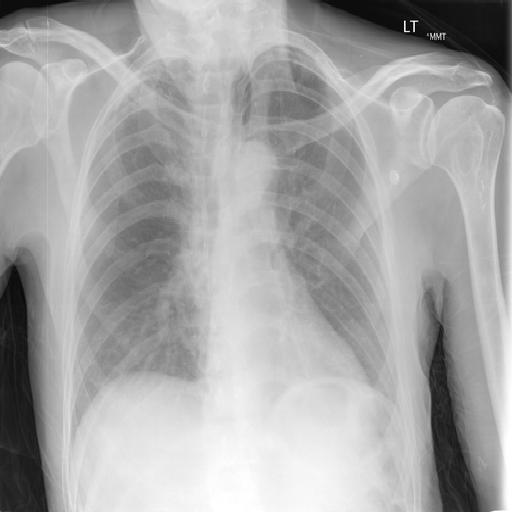

In [23]:
Image('images/2509.jpg')

### Image transform

In [24]:
def get_image_transform(
    image_size = (256, 256),
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
):
    if type(image_size) is int:
        use_center_crop = True
    elif type(image_size) is list or type(image_size) is tuple:
        use_center_crop = False
        assert len(image_size) == 2
    else: assert False

    tf_resize = T.Resize(image_size)
    tf_normalize = T.Normalize(mean, std)
    tf_totensor = T.ToTensor()
    if use_center_crop:
        tf_ccrop = T.CenterCrop(image_size)
        default_transform = T.Compose([tf_resize, tf_ccrop, tf_totensor, tf_normalize])
    else:
        default_transform = T.Compose([tf_resize, tf_totensor, tf_normalize])
    return default_transform

In [25]:
transform = get_image_transform(image_size=metadata['image_transform_kwargs']['image_size'])

# Generating and visualizing reports with CRG

In [34]:
class ReportGenerationVisualizer:
    
    def __init__(self, model, reports, transform, tokenizer, chexpert_one_hot_offset):
        self.model = model
        self.reports = reports
        self.transform = transform
        self.tokenizer = tokenizer
        self.chexpert_one_hot_offset = chexpert_one_hot_offset
        self.available_idxs = [i for i, r in enumerate(reports['reports']) if os.path.exists(f'images/{r["filename"][:-4] }.jpg')]
        print(f'Num reports with images: {len(self.available_idxs)}')
        print(f'Num reports without images: {len(reports["reports"]) - len(self.available_idxs)}')
    
    def generate_and_visualize_report(self, idx):

        print(colored('====== Ground-truth Image & Report =======', 'blue'))

        idx = self.available_idxs[idx]
        gt_report = self.reports['reports'][idx]

        # display image
        plt.figure(figsize=(8, 8))
        plt.imshow(PILImage.open(f'images/{ gt_report["filename"][:-4] }.jpg').convert('RGB'))
        plt.show()

        pprint(gt_report)
        print()

        # partient's background
        if gt_report['background']:
            print(colored('Background:', attrs=['bold']))
            print(gt_report['background'])
            
        # ground-truth report
        print(colored('Report:', attrs=['bold']))
        gt_text = '. '.join(gt_report['sentences'][i] for i in gt_report['matched'])
        gt_text = self.tokenizer.clean_text(gt_text)
        print(textwrap.fill(gt_text, width=70))

        print()
        print(colored('====== Ground-truth report split into topics =======', 'blue'))

        for q,a in gt_report['qa'].items():
            q = int(q)
            print(colored(self.reports['questions'][q], attrs=['bold']), end=' ')
            print(textwrap.fill('. '.join(gt_report['sentences'][i] for i in a), width=70))

        # questions
        chexpert_questions = [self.chexpert_one_hot_offset + i for i in range(len(CHEXPERT_LABELS))]
        mined_questions = gt_report['question_ids']
        questions = torch.tensor(chexpert_questions + mined_questions)
        batch_size = len(questions)
        questions = questions.to(DEVICE)

        # image batch
        img_path = f'images/{gt_report["filename"][:-4]}.jpg'
        img = PILImage.open(img_path).convert('RGB')
        img = self.transform(img)
        img_batch = img.unsqueeze(0).expand(batch_size, -1, -1, -1)
        img_batch = img_batch.to(DEVICE)

        # obtain answers with model
        with torch.set_grad_enabled(False):
            self.model.train(False)
            output = self.model(
                raw_images=img_batch,
                questions=questions,
                max_answer_length=20,
                mode='test',
                device=DEVICE,
            )
        answers = [tokenizer.ids2string(x) for x in tokenizer.clean_batch(output['pred_answers'])]

        print()
        print(colored('====== Generated report (mined topics) =======', 'blue'))
        
        for i, qid in enumerate(gt_report['question_ids']):
            print(colored(self.reports['questions'][qid], attrs=['bold']), answers[i + len(CHEXPERT_LABELS)])
        gen_report_mined = tokenizer.clean_text('. '.join(answers[len(CHEXPERT_LABELS):]))
        print()
        avg = 0
        for i in range(1, 5):
            bleu_score = BLEUScore(n_gram=i)
            score = bleu_score([gen_report_mined], [[gt_text]])
            print(f'bleu_{i}: {score:.4f}')
            avg += score
        print(f'bleu (avg): {(avg/4):.4f}')

        print()
        print(colored('====== Generated report (CheXpert topics) =======', 'blue'))

        for i, label in enumerate(CHEXPERT_LABELS):
            print(colored(label, attrs=['bold']), answers[i])
        gen_report_chexp = tokenizer.clean_text('. '.join(answers[:len(CHEXPERT_LABELS)]))
        print()
        avg = 0
        for i in range(1, 5):
            bleu_score = BLEUScore(n_gram=i)
            score = bleu_score([gen_report_chexp], [[gt_text]])
            print(f'bleu_{i}: {score:.4f}')
            avg += score
        print(f'bleu (avg): {(avg/4):.4f}')

In [35]:
rgv = ReportGenerationVisualizer(
    model=model,
    reports=reports,
    transform=transform,
    tokenizer=tokenizer,
    chexpert_one_hot_offset=metadata['iuxray_vqa_trainer_kwargs']['chexpert_one_hot_offset'])

Num reports with images: 3526
Num reports without images: 401


====== Ground-truth Image & Report =======


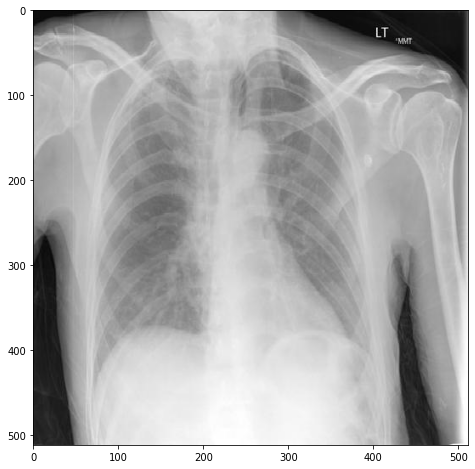

{'background': 'XXXX-year-old XXXX with chest pain.',
 'filename': '2509.xml',
 'invalid': [],
 'matched': [0, 1, 2, 3, 4],
 'qa': {'26': [1],
        '37': [4],
        '48': [3],
        '59': [0, 3],
        '63': [1],
        '68': [2],
        '73': [2]},
 'question_ids': [59, 26, 63, 68, 73, 48, 37],
 'sentences': ['The lungs are hyperexpanded , with increased AP diameter of '
               'the chest',
               'The cardiomediastinal silhouette is stable and normal',
               'There is no pneumothorax or large pleural effusion',
               'No acute cardiopulmonary abnormality',
               'Chronic changes consistent with emphysema'],
 'unmatched': []}

Background:
XXXX-year-old XXXX with chest pain.
Report:
the lungs are hyperexpanded , with increased ap diameter of the chest
. the cardiomediastinal silhouette is stable and normal . there is no
pneumothorax or large pleural effusion . no acute cardiopulmonary
abnormality . chronic changes consistent with em

In [36]:
rgv.generate_and_visualize_report(0)

====== Ground-truth Image & Report =======


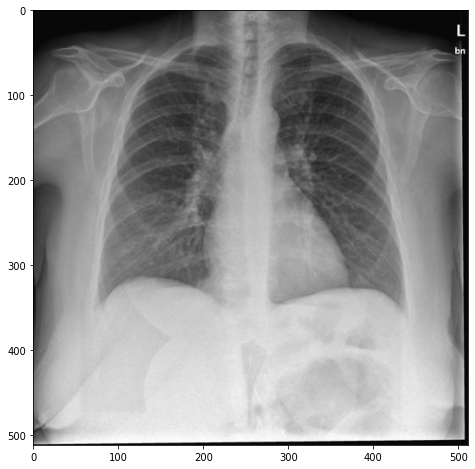

{'background': 'preop knee replacement surgery and XXXX',
 'filename': '3320.xml',
 'invalid': [0],
 'matched': [1, 2, 3],
 'qa': {'16': [2, 3], '48': [1], '59': [1]},
 'question_ids': [59, 48, 16],
 'sentences': ['Chest.',
               'Heart size normal lungs are clear',
               'Right knee',
               'Severe osteoarthritis all 3 compartments'],
 'unmatched': []}

Background:
preop knee replacement surgery and XXXX
Report:
heart size normal lungs are clear . right knee . severe osteoarthritis
all compartments

====== Ground-truth report split into topics =======
lungs? Heart size normal lungs are clear
heart? Heart size normal lungs are clear
bones? Right knee. Severe osteoarthritis all 3 compartments

====== Generated report (mined topics) =======
lungs? lungs clear no focal consolidation . no cardiopulmonary process
heart? heart size normal
bones? no osseous abnormality

bleu_1: 0.4118
bleu_2: 0.2269
bleu_3: 0.1508
bleu_4: 0.0000
bleu (avg): 0.1974

====== Generated 

In [37]:
rgv.generate_and_visualize_report(1234)

====== Ground-truth Image & Report =======


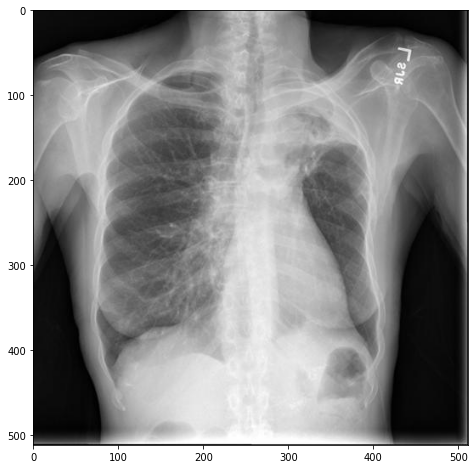

{'background': 'lung cancer followup',
 'filename': '1446.xml',
 'invalid': [],
 'matched': [0, 2, 3],
 'qa': {'39': [0], '48': [2], '59': [0], '68': [0, 3], '8': [0]},
 'question_ids': [59, 68, 8, 39, 48],
 'sentences': ['Further fibrosis and collapse of the left upper lobe with left '
               'apical pleural thickening',
               'No evidence of recurrence',
               'Heart size normal',
               'No effusion'],
 'unmatched': [1]}

Background:
lung cancer followup
Report:
further fibrosis and collapse of the left upper lobe with left apical
pleural thickening . heart size normal . no effusion

====== Ground-truth report split into topics =======
lungs? Further fibrosis and collapse of the left upper lobe with left apical
pleural thickening
pleural space? Further fibrosis and collapse of the left upper lobe with left apical
pleural thickening. No effusion
apical zone? Further fibrosis and collapse of the left upper lobe with left apical
pleural thickening
fibr

In [38]:
rgv.generate_and_visualize_report(2000)

====== Ground-truth Image & Report =======


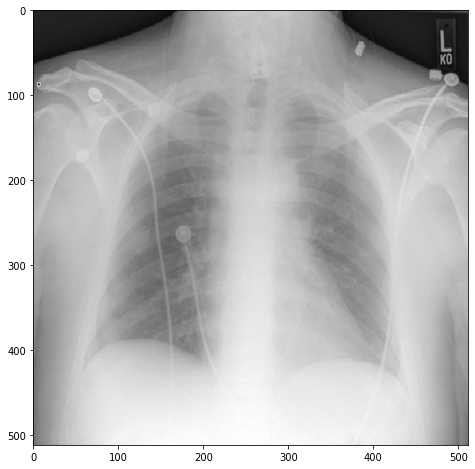

{'background': 'Rule out pneumonia',
 'filename': '694.xml',
 'invalid': [],
 'matched': [0, 1, 2, 3, 4],
 'qa': {'16': [3],
        '26': [0],
        '48': [4],
        '59': [1, 4],
        '63': [3],
        '68': [2],
        '76': [0],
        '88': [3]},
 'question_ids': [76, 26, 59, 68, 16, 63, 88, 48],
 'sentences': ['The cardiac silhouette and pulmonary vascularity are normal',
               'The lungs are clear',
               'There is no evidence of pleural effusion',
               'Postoperative changes are noted in the mediastinum and lower '
               'cervical spine',
               'No evidence of acute cardiopulmonary disease'],
 'unmatched': []}

Background:
Rule out pneumonia
Report:
the cardiac silhouette and pulmonary vascularity are normal . the
lungs are clear . there is no evidence of pleural effusion .
postoperative changes are noted in the mediastinum and lower cervical
spine . no evidence of acute cardiopulmonary disease

====== Ground-truth report 

In [39]:
rgv.generate_and_visualize_report(-125)